In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import datetime
import gmplot
import matplotlib.colors as cl

### Functions

In [2]:
def distance(longitude1,latitude1,longitude2,latitude2):
    
    #this is the same as the Haversine metric from sklearn which is output as A in nearest neighbor match below
    #convert from decimal degrees to radians
    long1 = np.radians(longitude1)
    long2 = np.radians(longitude2)
    lati1 = np.radians(latitude1)
    lati2 = np.radians(latitude2)
    
    dlong = long2 - long1
    dlati = lati2 - lati1
    
    #haversine formula for a great circle distance
    a = np.square(np.sin(dlati/2))+np.multiply(np.multiply(np.cos(lati1),np.cos(lati2)),np.square(np.sin(dlong/2)))
    c = 2 * np.arcsin(np.sqrt(a))
    
    r = 3955.082 #earth's radius in miles at London (0 elevation)
    
    return c*r

def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)
        
## following three functions from Greg McCracken
# usuage examples with accident dataframe "df"
# df = df.loc[is_str(df.Time.values),:]  (this would get rid of any None in a string feature. get_hour won't work with Nones)
# df[['y','m','d']] = get_ymd(df.Date.values)
# df['h'] = get_hour(df.Time.values)

def is_str(x):
    Nx = len(x)
    I = np.ones(Nx).astype(bool)
    for ii in range(Nx):
        if type(x[ii]) != str:
            I[ii] = False
    return I

def get_hour(T):
    Nt = len(T)
    H = np.zeros(Nt).astype(int)
    for ii in range(Nt):
        s = T[ii].split(':')
        h = int(s[0])
        m = int(s[1])
        if m > 30:
            h += 1
        H[ii] = h % 24
    return H

def get_ymd(D):
    Nd = len(D)
    ymd = np.zeros((Nd,3)).astype(int)
    for ii in range(Nd):
        s = D[ii].split('-')
        for nn in range(3):
            ymd[ii,nn] = int(s[nn])
    return ymd

## Load in Data

In [3]:
##arrays needed for data sorting

#road class conversion of CYCLANDS 1st_Road_Class and 2nd_Road_Class variables
#note that 'na' corresponds to no 2nd road. 1st_Road_class does not have these values (-1)
road_classes = np.array(['','M','A(M)','A','B','C','U','na'])

##upper left, lower right corners of Greater London (lat,long)
corners = [(51.68863717738605, -0.5468983269149709),(51.28157836053724, 0.3732066186882609)]

##upper left, lower right corners of Central London (lat,long)
# corners = [(51.543,-0.179),(51.475,0.023)]

In [4]:
#collision data from CYCLANDS
collisions = pd.read_csv('./uk_gov/cycling_safety_uk_gov.csv',parse_dates=['Date'])
#combine road_class and road_name variables to match single variable formatting of aadf
collisions['Road_name'] = road_classes[collisions['1st_Road_Class'].values].astype(object)+collisions['1st_Road_Number'].apply(str).values
collisions['Road_name2'] = road_classes[collisions['2nd_Road_Class'].values].astype(object)+collisions['2nd_Road_Number'].apply(str).values

#remove 0 road number from U and C road classes to match aadf (these are just filler road numbers and not real numbes)
collisions.Road_name = collisions.Road_name.str.replace('U0','U')
collisions.Road_name = collisions.Road_name.str.replace('C0','C')
collisions.Road_name2 = collisions.Road_name2.str.replace('U0','U')
collisions.Road_name2 = collisions.Road_name2.str.replace('C0','C')

#annual average daily flow traffic data from https://roadtraffic.dft.gov.uk
aadf = pd.read_csv('./uk_gov/dft_traffic_counts_aadf.csv',low_memory=False,parse_dates=['Year'])

In [5]:
#add boolean variable for in London
collisions['in_london']=[(collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()[0]


In [6]:
collisions['aadf_'+aadf.columns] = np.nan
collisions['distance_to_cp'] = np.nan
collisions['match'] = False

## Geomatch data

In [7]:
from sklearn.neighbors import NearestNeighbors

matches = 0
london_col = 0
london_col_nonan = 0
too_fars = 0

#how many aadf neighbors to compare each collision to. Typically each year has ~25 that have k>10.
k_neighbor = 50

for year in np.arange(2005,2019):
    
    #slice data on year and within Greater London
    aadf_year = aadf[(aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])].copy()
    collisions_year = collisions[(collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])].copy()
    
    aadf_mask = (aadf.Year.dt.year == year) & (aadf.Longitude > corners[0][1]) & (aadf.Longitude < corners[1][1]) & (aadf.Latitude > corners[1][0]) & (aadf.Latitude < corners[0][0])
    col_mask = (collisions.Date.dt.year == year) & (collisions.Longitude > corners[0][1]) & (collisions.Longitude < corners[1][1]) & (collisions.Latitude > corners[1][0]) & (collisions.Latitude < corners[0][0])
    
    #find nearest k_neighbor aadf cp neighbors to collisions
    #haversine metric used here with lat/long converted to radians. Euclidean metric glives slightly wrong ordering of neighbors
    #A is distance from collision to each neighbor
    #B is aadf index of neighbor
    #A and B are of size (len(collisions+year),k_neighbor)
    neigh = NearestNeighbors(n_neighbors=k_neighbor,radius=1,metric='haversine')
    neigh.fit(np.radians(aadf_year[['Latitude','Longitude']]))
    A,B = neigh.kneighbors(np.radians(collisions_year[['Latitude','Longitude']]),k_neighbor)
    
    #find index of correct neighbor match
    match_idx = np.zeros((len(B),k_neighbor))
    
    #loop through k_neighbors and mark which ones have Road_name that matches 1st collision road name
    for i in range(k_neighbor):
        match_idx[aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name.values,i] = 1
    
    #find closest neighbor with matching road names
    #need to set collisions with no match to -1 to not be confused with those where first neighbor (i.e. k=0) is match
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)    #this is 1d array of len(collisions_year) of which neighbor in B[i,:] is correct match (-1 is no match)
    
    #for collisions with no aadf match (i.e. check[i]=-1), look at 2nd labeled road in collision (Road_name2)
    for i in range(k_neighbor):
        match2 = aadf_year.iloc[B[:,i].flatten().tolist()].Road_name.values == collisions_year.Road_name2.values
        match_idx[match2 & (check == -1),i] = 1
    
    #repeat this process now that 2nd road name matches have been filled in
    invalid_val = -1
    no_match = match_idx != 0
    check = np.where(no_match.any(axis=1), no_match.argmax(axis=1), invalid_val)
    
    #create boolean mask of matches
    match = np.where(check.astype(int) >= 0,True,False)
    
    #calculate distance from collision to match
    dist = A[np.arange(B.shape[0]),check]*3955.082
    
    #how many correct matches are within Link_length_miles
    too_far = (dist[match] <= aadf_year.iloc[B[np.arange(B.shape[0]),check][match]].Link_length_miles.values)
    
    #add correct aadf matches to collisions
    collisions.loc[np.where(col_mask)[0][match],'aadf_'+aadf.columns] = aadf.loc[aadf_mask].iloc[B[np.arange(B.shape[0]),check]][match].values
    #add correct matches to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'match'] = True
    #add distance_to_cp to collisions
    collisions.loc[np.where(col_mask)[0][match][too_far],'distance_to_cp'] = A[np.arange(B.shape[0]),check][match][too_far]
    
    ##calculate statistics
    
    B_match = B[np.arange(B.shape[0]),check][match]
    
    #count collisions in London
    london_col += len(collisions_year)
    london_col_nonan += len(collisions_year)
    
    #how many matches
    matches += match.sum()
    
    #of unmatched collisions, how many were U/C roads
    #try/except used as sometimes all U roads have matches
    try:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['U','C']].values.sum()/(check == -1).sum()
    except:
        Unlabeled = collisions_year[check == -1].Road_name.value_counts().loc[['C']].values.sum()/(check == -1).sum()

    #log how many total are outside boundary
    too_fars += too_far.sum()
    
    #which percent of collisions outside of Link_length_miles are due to nan Link_length_miles
    nan_outside = np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()/(np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()+(dist[match] > aadf_year.iloc[B_match].Link_length_miles.values).sum())
    
    #remove london collisions from count with nan Link_length_miles
    london_col_nonan -= np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()
    
    #how many collisions are within Link_length_miles
    #needed to cauclate large k's within boundaries
    too_far_all = (dist <= aadf_year.iloc[B[np.arange(B.shape[0]),check]].Link_length_miles.values)
        
    
    print(year)
    print('mean distance to CP:',dist[match].mean())
    print('median distance to CP:',np.median(dist[match]))
    print('max distance to CP:',dist[match].max())
    print('min distance to CP:',dist[match].min())
    print()
    print('mean distance to CP within tracker boundary:',dist[match][too_far].mean())
    print('median distance to CP within tracker boundary:',np.median(dist[match][too_far]))
    print('max distance to CP within tracker boundary:',dist[match][too_far].max())
    print('min distance to CP within tracker boundary:',dist[match][too_far].min())
    print()
    print('Correct geo match:',match.sum())
    print('Correct geo match within tracker boundary:',too_far.sum())
    print('k>9 matches inside boundary',np.where((check > 9) & too_far_all,1,0).sum())
    print('largest k within boundary',np.max(check[too_far_all]))
    print('% outside boundary with nan value',nan_outside)
    print()
    print('Unlabeled unmatched collisions:',Unlabeled)
    print()
    print('Total London collisions:',len(collisions_year))
    print()
    print('% matched:',match.sum()/len(collisions_year))
    print('% matched in boundary:',too_far.sum()/len(collisions_year))
    print('% matched in boundary (not counting nan):',too_far.sum()/(len(collisions_year)-np.isnan(aadf_year.iloc[B_match].Link_length_miles.values).sum()))
    
    print()
    print()
    print()

print('total')
print('Correct geo match:',matches)
print('Correct geo match within tracker boundary:',too_fars)
print('Total London collisions:',london_col)
print('% matched:',matches/london_col)
print('% matched in boundary:',too_fars/london_col)
print('% matched in boundary (not counting nan):',too_fars/london_col_nonan)

2005
mean distance to CP: 0.4139035254218025
median distance to CP: 0.2500321794859528
max distance to CP: 5.358011966852259
min distance to CP: 0.0024900736781821777

mean distance to CP within tracker boundary: 0.2007601698757958
median distance to CP within tracker boundary: 0.1295936783983048
max distance to CP within tracker boundary: 2.612617688753044
min distance to CP within tracker boundary: 0.0024900736781821777

Correct geo match: 3073
Correct geo match within tracker boundary: 1803
k>9 matches inside boundary 23
largest k within boundary 46
% outside boundary with nan value 0.8913385826771654

Unlabeled unmatched collisions: 0.176

Total London collisions: 3323

% matched: 0.924766777008727
% matched in boundary: 0.5425820042130605
% matched in boundary (not counting nan): 0.8229119123687814



2006
mean distance to CP: 0.39717479766241154
median distance to CP: 0.2433006112990845
max distance to CP: 4.939897207887375
min distance to CP: 0.0025593925852251775

mean distance

In [8]:
collisions.to_csv('./DataFrames/combined_collisions.csv',index=False)

## Plot results

In [9]:
api_key = get_file_contents('./Keys/google_maps.txt')

Collision: 4556
Neighbor index of match: -1
Found match: False
Match within boundary: False


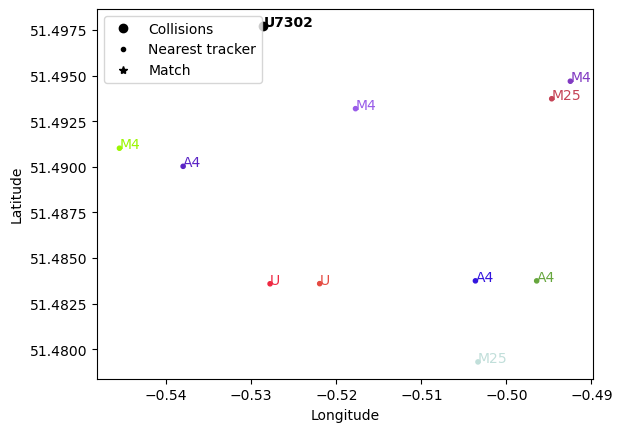

In [10]:
#index of collision to plot
plotN = np.random.randint(len(collisions_year))

#how many neighbors to plot
p_neighbor = 10

#if True will create .html with labeled map
gmp = False

print('Collision:',plotN)
print('Neighbor index of match:',check[plotN])
print('Found match:',match[plotN])
print('Match within boundary:',too_far_all[plotN])

#randomly create colors for neighbors
colors = np.random.rand(p_neighbor,3)

##plot collision
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#collision marker
ax.scatter(collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude,c='black')
#collision text Road_name
ax.annotate(collisions_year.iloc[plotN].Road_name, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude),color='black',weight='bold')

##plot neighbors
#neighbor markers
ax.scatter(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values,c=colors,marker='.')
#neibhor text Road_name
for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,:p_neighbor].flatten().tolist()].Latitude.values)):
    if i == check[plotN]:
        ax.annotate(txt, (long,lat),color=colors[i],weight='bold')
    else:
        ax.annotate(txt, (long,lat),color=colors[i])

#if match, plot start on matched neighbor
if check[plotN] != -1:
    ax.scatter(aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN,check[plotN]].flatten().tolist()].Latitude.values,c='black',marker='*',s=100)

#plot text of collision Road_name2
yspan = np.diff(ax.get_ylim())[0]   #calculates how far above first text to place second text
ax.annotate(collisions_year.iloc[plotN].Road_name2, (collisions_year.iloc[plotN].Longitude,collisions_year.iloc[plotN].Latitude+yspan/20),color='black',weight='bold')    

#collision marker
ax.scatter(collisions.loc[np.where(col_mask)[0][plotN]].aadf_Longitude,collisions.loc[np.where(col_mask)[0][plotN]].aadf_Latitude,c='orange')

##create legend
#Get artists and labels for legend and chose which ones to display
handles, labels = ax.get_legend_handles_labels()
display = (0,1,2)

#Create custom artists
simArtist = plt.Line2D((0,1),(0,0), color='k', marker='o', linestyle='')
anyArtist = plt.Line2D((0,1),(0,0), color='k',marker='.',linestyle='')
matchArtist = plt.Line2D((0,1),(0,0), color='k',marker='*',linestyle='')

#plot legend
plt.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist,matchArtist],
          [label for i,label in enumerate(labels) if i in display]+['Collisions', 'Nearest tracker','Match'])

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

if gmp:
    gmap1 = gmplot.GoogleMapPlotter(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude,16,apikey=api_key)

    gmap1.marker(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, color='blue')
    road_name = collisions_year.iloc[plotN].Road_name
    gmap1.text(collisions_year.iloc[plotN].Latitude,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')
    road_name = collisions_year.iloc[plotN].Road_name2
    gmap1.text(collisions_year.iloc[plotN].Latitude-0.0002,collisions_year.iloc[plotN].Longitude, text=road_name,color='blue')

    gmap1.scatter(aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,c='red')
    for i,(txt,long,lat) in enumerate(zip(aadf_year.iloc[B[plotN].flatten().tolist()].Road_name.values,aadf_year.iloc[B[plotN].flatten().tolist()].Longitude.values,aadf_year.iloc[B[plotN].flatten().tolist()].Latitude.values)):
        if i != check[plotN]:
            gmap1.text(lat,long,txt,color='red')

    gmap1.marker(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude,color='green')
    road_name = aadf_year.iloc[B[plotN,check[plotN]]].Road_name
    gmap1.text(aadf_year.iloc[B[plotN,check[plotN]]].Latitude,aadf_year.iloc[B[plotN,check[plotN]]].Longitude, text=road_name,color='green')

    gmap1.draw('./Plots/map'+str(plotN)+'.html')